# Single label Classifier - AF Detection

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import sys
sys.path.append("../../tutorials/fastai/old/") # go to parent dir

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer

import mlflow
import mlflow.sklearn


Bad key "text.kerning_factor" on line 4 in
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Helper functions

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
def print_fscores(m, x, y):
    res = [f1_score(y, m.predict(x), average='weighted'), fbeta_score(y, m.predict(x), beta=2)]
    print(res)

## Now we can choose which lead data to load

### Lead 1 data:

In [5]:
df_raw = pd.read_feather('datasets/base/pyhs-raw-lead1-corrected')
display_all(df_raw.T)

0            1            2            3     \
age                      64           24           59           14   
sex                       1            1            0            1   
fmax                8.20328      2.15043      1.05485      7.64504   
mean_RR             4460.78      9963.95      7031.67      6695.09   
mean_R_Peaks         190690       161291       228946  4.04914e+06   
mean_T_Peaks        84.1667      183.905      120.467      56.7143   
mean_P_Peaks        77.6667      44.0476      58.7333      57.1905   
mean_Q_Peaks         -32.75     -38.1905        -36.2     -148.619   
mean_S_Peaks       -46.6667     -212.048     -130.267     -121.952   
median_RR              4017         9914         6993         6660   
median_R_Peaks       163434       245336       183364  4.22689e+06   
std_RR              2788.58      5793.79      4059.13      4090.41   
std_R_Peaks          170403       120275       214377       884262   
var_RR          8.23363e+06  3.43673e+07  1.70447e+07  1.75282e+07   
var_R_Peaks     3.07451e+10  1.48104e+10  4.75421e+10  8.19154e+11   
skew_RR            0.326896   0.00822937    0.0160395    0.0310137   
skew_R_Peaks       0.452789   -0.0122815     0.102263     -4.32584   
kurt_RR             -1.1146     -1.19623     -1.17866     -1.22044   
kurt_R_Peaks       -1.28517     -1.95524     -1.85952      16.8351   
mean_P_Onsets       4617.67      10309.6      6736.27      6795.24   
mean_T_Offsets      5106.17      10776.3       7255.6      7248.29   
HRV                 300.262      252.052       247.39      319.845   
label                   PAC       Normal          PAC       Normal   

                       4            5            6            7     \
age                      40           64           56           76   
sex                       1            0            0            0   
fmax                2.18261      3.89556      17.0068      1.80072   
mean_RR             5615.25       9609.8      4754.85      4782.45   
mean_R_Peaks    1.30268e+06       280331       331673       104983   
mean_T_Peaks            196       133.88      63.4167      60.7857   
mean_P_Peaks        40.8182         2.92         0.25      67.6429   
mean_Q_Peaks       -218.636        -70.8     -13.3333     -26.3571   
mean_S_Peaks       -259.455       -80.24     -157.833     -129.214   
median_RR              5640         9780         4879         4504   
median_R_Peaks  1.11847e+06      28940.1        13556       102426   
std_RR              3206.38      5480.42       2831.8      3017.22   
std_R_Peaks     1.26993e+06       268252       354536        44664   
var_RR          1.07279e+07  3.06357e+07  8.33985e+06  9.53712e+06   
var_R_Peaks     1.68284e+12  7.33984e+10  1.30724e+11  2.08987e+09   
skew_RR           -0.014445   -0.0355583    0.0221538    0.0949298   
skew_R_Peaks      0.0459666     0.163273     0.207103   0.00224062   
kurt_RR             -1.2168     -1.19116     -1.09702     -1.29848   
kurt_R_Peaks       -1.94023     -1.80995     -1.88757    -0.886534   
mean_P_Onsets       5709.27      9375.28       4810.5      5261.14   
mean_T_Offsets      6233.82      9916.24      5340.17      5768.57   
HRV                 237.255      194.175      205.367      239.317   
label                  RBBB        I-AVB           AF           AF   

                       8            9            10           11    \
age                      89           42           80           62   
sex                       0            1            1            0   
fmax                4.30172      1.40056     0.785939      3.36088   
mean_RR              4958.5      5027.26      7077.64      15260.4   
mean_R_Peaks    1.52599e+06       186787       179436  2.54788e+06   
mean_T_Peaks        39.4615      203.538      44.8947      6.87179   
mean_P_Peaks        10.7857      33.4615      31.7368      28.8718   
mean_Q_Peaks       -74.3571     -87.1538     -20.8947     -116.333   
mean_S_Peaks         -137.5    

### Lead 2 data seems to give better results:

In [5]:
df_raw = pd.read_feather('datasets/corrected/pyhs-raw-lead2-corrected')
display_all(df_raw.T)

0            1            2            3     \
age                      64           24           59           14   
sex                       1            1            0            1   
fmax                4.60184      1.05021      1.05485      4.57274   
mean_RR             5164.82      9965.07      7262.19         6977   
mean_R_Peaks    3.21419e+06  1.42354e+06       782051       544773   
mean_T_Peaks        115.636       371.35      172.267      108.762   
mean_P_Peaks        13.1818     -19.5714     -8.73333      44.0476   
mean_Q_Peaks       -114.364     -114.714     -95.9333     -72.4762   
mean_S_Peaks       -54.0909      -270.81     -39.0667     -157.095   
median_RR              5166         9920         7150         7275   
median_R_Peaks   4.3649e+06  2.37452e+06      43328.4       615665   
std_RR              2986.46      5793.85      4186.15      4060.39   
std_R_Peaks     2.39316e+06  1.26495e+06       779588       204638   
var_RR          9.47635e+06   3.4368e+07   1.8108e+07  1.72036e+07   
var_R_Peaks     6.08516e+12   1.6382e+12  6.28016e+11  4.36973e+10   
skew_RR           0.0022395   0.00818842   0.00841972    -0.099483   
skew_R_Peaks      -0.497951   -0.0336479     0.119925     -2.12018   
kurt_RR            -1.25653     -1.19657     -1.19276     -1.21384   
kurt_R_Peaks       -1.59331     -1.98235     -1.89579      2.76596   
mean_P_Onsets       5029.09      10306.8       6725.6       6830.1   
mean_T_Offsets      5508.91          NaN      7256.93      7244.29   
HRV                 324.786       250.69      244.448      297.769   
label                   PAC       Normal          PAC       Normal   

                       4            5            6            7     \
age                      40           64           56           76   
sex                       1            0            0            0   
fmax                8.54856      3.89556      1.30052       7.0028   
mean_RR                4981      9610.75      4971.92       5241.4   
mean_R_Peaks    1.03544e+06       464155       366945   1.1063e+06   
mean_T_Peaks        25.8182       175.64       164.25      40.2667   
mean_P_Peaks        95.2727         16.6      1.33333           34   
mean_Q_Peaks       -62.3636      -113.76     -55.5833     -42.4667   
mean_S_Peaks       -360.364       -43.32     -166.333     -165.267   
median_RR              4715         9782         5016         5534   
median_R_Peaks  1.70297e+06      57474.8        60437  1.33159e+06   
std_RR               3011.1      5480.61      2985.73      2827.17   
std_R_Peaks          842957       436835       353303       573251   
var_RR           9.5439e+06  3.06378e+07  9.28603e+06  8.41357e+06   
var_R_Peaks     7.47975e+11  1.94642e+11  1.30024e+11  3.45912e+11   
skew_RR            0.134001   -0.0355991   -0.0700177    -0.166069   
skew_R_Peaks      -0.406748     0.132798      0.19688      -1.1105   
kurt_RR            -1.14666     -1.19105     -1.23791     -1.14911   
kurt_R_Peaks       -1.83252      -1.8626     -1.82098    -0.275214   
mean_P_Onsets       5675.82      9379.76       4792.5       5127.2   
mean_T_Offsets      6216.55      9913.76      5332.83      5652.93   
HRV                 286.387      194.706      212.797       265.59   
label                  RBBB        I-AVB           AF           AF   

                       8            9            10           11    \
age                      89           42           80           62   
sex                       0            1            1            0   
fmax                4.30172      2.10084      2.21492      1.57252   
mean_RR             5190.95      4933.36      7069.45      15739.2   
mean_R_Peaks         791539  1.67609e+06       617527  2.65317e+06   
mean_T_Peaks        5.53846     -24.1538     -6.31579     -20.8421   
mean_P_Peaks        56.7143      58.9231      3.63158      92.8649   
mean_Q_Peaks       -50.9286      12.7692    -0.315789     -52.1316   
mean_S_Peaks       -104.214    

In [6]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_raw['PT_duration'] = df_raw['mean_T_Offsets'] - df_raw['mean_P_Onsets']
df_raw.drop(['mean_T_Offsets', 'mean_P_Onsets'], axis=1, inplace=True)

## Split between Train and Validation Datasets

### Training Set (80%) - Validation (20%)

In [8]:
df_af = df_raw[(df_raw.loc[:, 'label'] == 'AF')]
df_af.reset_index(inplace=True)
df_train_af = df_af.sample(frac=0.8)

id_train = list(df_train_af.index)
id_eval = [y for y in range(len(df_af)) if y not in id_train]
df_eval_af = df_af.loc[id_eval,:]
len(df_eval_af), len(df_train_af), len(df_af)

(244, 977, 1221)

In [9]:
df_rest = df_raw[(df_raw.loc[:, 'label'] != 'AF')]
df_rest.reset_index(inplace=True)
df_train_rest = df_rest.sample(frac=0.8)

id_train = list(df_train_rest.index)
id_eval = [y for y in range(len(df_rest)) if y not in id_train]

df_eval_rest = df_rest.loc[id_eval,:]
len(df_eval_rest), len(df_train_rest), len(df_rest)

(1131, 4525, 5656)

### We check to see if the labels we sampled in the same proportion as they appear in the original dataset

In [10]:
labels = pd.get_dummies(df_train_rest['label'])
labels.describe()

,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,4525.000000,4525.000000,4525.000000,4525.000000,4525.000000,4525.000000,4525.000000,4525.000000
mean,0.123094,0.035580,0.162210,0.094807,0.112928,0.297017,0.142320,0.032044
std,0.328581,0.185261,0.368684,0.292980,0.316540,0.456994,0.349417,0.176137
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Renaming everything else as "Non-AF" in both sets

In [11]:
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'I-AVB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'LBBB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'Normal'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'PAC'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'PVC'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'RBBB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'STD'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'STE'] = 'Non-AF'

df_eval_rest['label'][df_eval_rest.loc[:, 'label'] == 'I-AVB'] = 'Non-AF'
df_eval_rest['label'][df_eval_rest.loc[:, 'label'] == 'LBBB'] = 'Non-AF'
df_eval_rest['label'][df_eval_rest.loc[:, 'label'] == 'Normal'] = 'Non-AF'
df_eval_rest['label'][df_eval_rest.loc[:, 'label'] == 'PAC'] = 'Non-AF'
df_eval_rest['label'][df_eval_rest.loc[:, 'label'] == 'PVC'] = 'Non-AF'
df_eval_rest['label'][df_eval_rest.loc[:, 'label'] == 'RBBB'] = 'Non-AF'
df_eval_rest['label'][df_eval_rest.loc[:, 'label'] == 'STD'] = 'Non-AF'
df_eval_rest['label'][df_eval_rest.loc[:, 'label'] == 'STE'] = 'Non-AF'

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

### We merge both sets into one

In [12]:
df_train = pd.concat([df_train_af, df_train_rest])
df_eval = pd.concat([df_eval_af, df_eval_rest])
df_train.drop('index', inplace=True, axis=1)
df_eval.drop('index', inplace=True, axis=1)

df_train

,age,sex,fmax,mean_RR,mean_R_Peaks,mean_T_Peaks,mean_P_Peaks,mean_Q_Peaks,mean_S_Peaks,median_RR,...,std_R_Peaks,var_RR,var_R_Peaks,skew_RR,skew_R_Peaks,kurt_RR,kurt_R_Peaks,HRV,label,PT_duration
665,90,1,3.501401,4652.000000,2.740312e+05,117.812500,50.687500,-41.187500,31.187500,4518.0,...,105637.911174,7.993366e+06,1.177933e+10,0.077223,-0.649985,-1.123717,0.286858,270.798921,AF,425.875000
855,53,0,7.903161,4873.000000,4.010795e+05,27.166667,34.291667,-26.625000,-151.333333,4890.0,...,56959.163368,9.203101e+06,3.374120e+09,0.034819,-0.478479,-1.198368,-0.256258,201.535803,AF,367.500000
238,87,0,2.100840,5037.500000,3.988924e+05,-17.500000,31.111111,15.722222,-217.555556,5193.0,...,97099.201150,8.831634e+06,9.924479e+09,-0.065867,-3.262503,-1.148265,10.667652,257.197548,AF,474.444444
351,64,0,0.631114,6583.800000,2.140456e+06,99.352941,58.588235,-55.411765,-63.470588,6626.0,...,766614.554261,1.382844e+07,6.186293e+11,-0.064037,-1.691290,-1.183790,2.696001,325.150653,AF,548.941176
116,70,0,1.400560,5114.857143,7.867733e+04,113.000000,9.533333,-34.400000,-149.800000,5146.0,...,60842.216599,8.969133e+06,3.838878e+09,-0.033918,0.056324,-1.195055,-1.852260,190.163283,AF,578.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3971,65,1,2.400960,5064.666667,4.629051e+05,202.666667,65.083333,-69.666667,168.083333,5186.0,...,301842.598997,9.555899e+06,9.646830e+10,-0.018123,-0.666368,-1.218235,-1.493673,306.024605,Non-AF,363.333333
4136,84,0,1.333587,10170.266667,1.825393e+06,-43.250000,169.464286,19.928571,-602.714286,10042.0,...,499639.813166,3.988105e+07,2.582482e+11,0.054750,-3.067844,-1.223976,8.326773,360.379446,Non-AF,581.357143
144,80,0,2.501000,5355.411765,1.021369e+06,179.846154,71.461538,-89.384615,-59.307692,5458.0,...,713752.365603,9.575179e+06,5.412826e+11,-0.095485,0.907777,-1.136835,2.166439,320.706739,Non-AF,439.692308
4376,47,1,2.182612,5453.840000,2.442687e+05,195.000000,70.818182,-68.545455,-228.909091,5498.0,...,245958.283080,1.153433e+07,6.301612e+10,0.011908,0.264066,-1.217385,-1.898689,237.965946,Non-AF,522.000000


In [13]:
df_eval

,age,sex,fmax,mean_RR,mean_R_Peaks,mean_T_Peaks,mean_P_Peaks,mean_Q_Peaks,mean_S_Peaks,median_RR,...,std_R_Peaks,var_RR,var_R_Peaks,skew_RR,skew_R_Peaks,kurt_RR,kurt_R_Peaks,HRV,label,PT_duration
3,91,1,6.402561,4626.833333,8.928119e+05,86.230769,-0.307692,-38.461538,-89.615385,4328.0,...,8.169956e+05,8.263207e+06,6.965028e+11,0.177945,-0.089672,-1.261479,-1.884596,213.594801,AF,600.461538
9,77,1,0.100040,4916.555556,5.677979e+05,32.312500,62.562500,-27.750000,-445.937500,4824.0,...,1.466578e+05,9.629537e+06,2.277372e+10,0.073021,-3.011382,-1.171292,9.200581,292.677397,AF,456.500000
11,64,1,2.701080,5224.434783,6.143282e+05,61.500000,33.090909,-19.318182,-35.545455,5228.0,...,1.578484e+05,8.956350e+06,2.604868e+10,0.019048,-1.504348,-1.218515,2.567179,221.363954,AF,333.363636
13,82,0,2.292049,12127.632653,2.014515e+05,68.129032,39.968750,-41.187500,-238.125000,12672.0,...,1.432135e+05,5.523005e+07,2.093741e+10,-0.068851,-0.520849,-1.329983,-1.552788,268.636526,AF,NaN
20,56,0,3.286653,7256.200000,3.040696e+06,49.869565,-0.304348,-91.000000,-159.739130,7642.0,...,1.769235e+06,1.678030e+07,3.238130e+12,-0.165809,-1.014608,-1.070114,-0.882557,252.875054,AF,557.130435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5632,70,1,1.700680,4997.111111,7.135225e+05,-62.250000,106.117647,-24.352941,-286.294118,4984.0,...,1.981135e+05,9.681871e+06,4.155772e+10,0.023640,-1.922294,-1.231320,4.943800,287.834818,Non-AF,NaN
5639,70,0,1.200480,4828.480000,1.081684e+05,21.000000,13.416667,-47.833333,-82.583333,4826.0,...,1.041406e+05,8.607071e+06,1.129715e+10,0.064251,0.183202,-1.248011,-1.818178,201.776692,Non-AF,432.666667
5645,49,0,0.347887,11565.675676,6.397865e+05,88.324324,77.135135,-79.351351,-278.351351,11632.0,...,6.032223e+04,4.431754e+07,3.739848e+09,-0.017416,1.640893,-1.199631,7.117026,308.425167,Non-AF,450.756757
5648,32,0,5.168389,6094.875000,8.763908e+05,219.133333,77.687500,-144.750000,-132.562500,6104.0,...,8.716814e+05,1.299534e+07,7.843391e+11,-0.012460,0.137188,-1.193440,-1.964744,201.171889,Non-AF,NaN


### Check to see if training set has the same AF and Non-AF proportion as in the original dataset

In [14]:
labels = pd.get_dummies(df_train['label'])
labels.describe()

,AF,Non-AF
count,5502.000000,5502.000000
mean,0.177572,0.822428
std,0.382187,0.382187
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


### We process our datasets and train our model

In [15]:
X_train, y_train, nas = proc_df(df_train, 'label')
X_eval, y_eval, nas = proc_df(df_eval, 'label', na_dict=nas)

In [20]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train, y_train)

m_af.score(X_train,y_train), m_af.score(X_eval, y_eval), m_af.oob_score_

CPU times: user 16.5 s, sys: 157 ms, total: 16.6 s
Wall time: 3.65 s


(1.0, 0.9287272727272727, 0.9278444202108325)

We compare the **R^2** metric with the **OOB R^2** so that we make sure we are not overfitting.

### Evaluation Metrics

print_fscores returns the sklearn [ f1_score, fbeta_score ] with beta = 2

This are the evaluation metrics we are actually interested in.

In [17]:
print_fscores(m_af, X_train, y_train)

[1.0, 1.0]


In [21]:
print_fscores(m_af, X_eval, y_eval)

[0.9244914716484377, 0.9734126290012243]


In [22]:
mlflow.set_experiment('AF_feature_testing')
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train.columns)))
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval), beta=2))
    #mlflow.sklearn.log_model(m_af, "Model")  

## Removing Redundant Features

By calculating a Dendrogram we look for features that may be providing the same information so we can remove them and end up with a cleaner model.

In [23]:
from scipy.cluster import hierarchy as hc

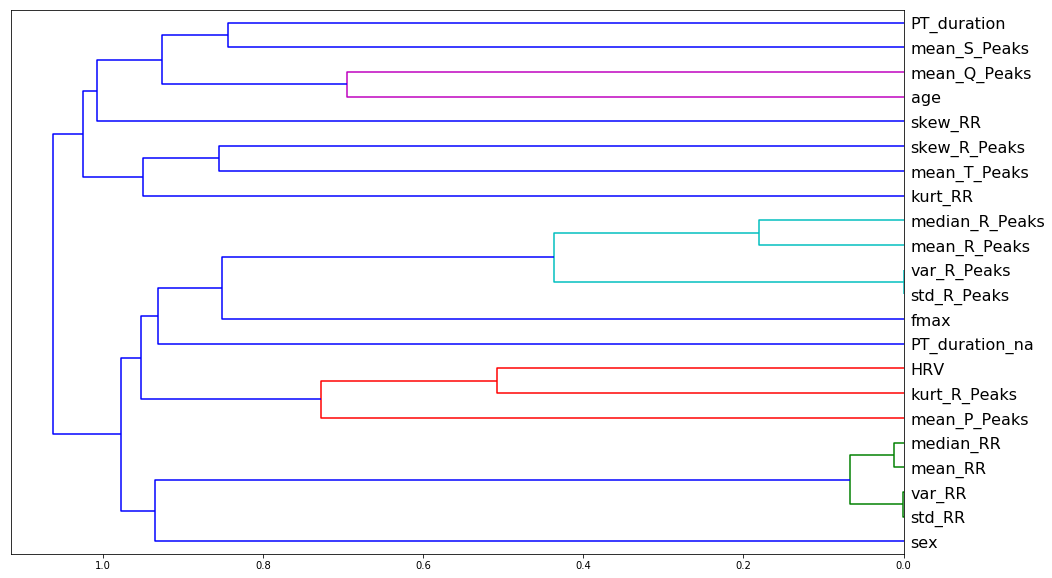

In [25]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

Given that the variance can be obtained from the std, and viceversa it's no surprise they seem to provide the same information. Let's try and remove them.

In [27]:
to_drop = ['var_R_Peaks']
X_train_drop = X_train.drop(to_drop, axis=1)
X_eval_drop = X_eval.drop(to_drop, axis=1)

In [59]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_drop, y_train)

print_fscores(m_af, X_eval_drop, y_eval)

CPU times: user 16.1 s, sys: 187 ms, total: 16.3 s
Wall time: 3.75 s
[0.9248114164904864, 0.9723437773499037]


In [32]:
mlflow.set_experiment('AF_feature_testing')
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_drop.columns)))
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval_drop), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval_drop), beta=2))
    #mlflow.sklearn.log_model(m_af, "Model")

## Looking at Feature Importance

We calculate the feature importance using the MDI (Mean Decrease in Impurity) method, with is the default for sklearn's Random Forests

In [33]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

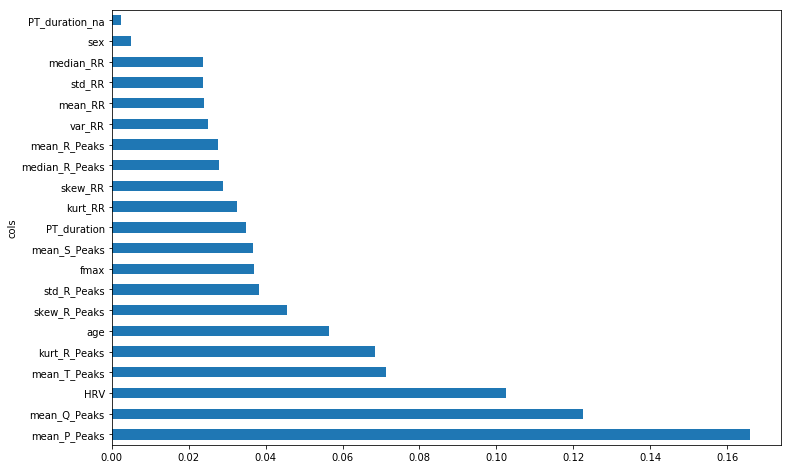

In [60]:
fi_mdi = rf_feat_importance(m_af, X_train_drop)
plot_fi(fi_mdi);

We now calculate feature importance using the MDA (Mean Decrease in Accuracy) method to compare. We can pass our own score algorithm so we will use the beta score since is the metric we will be optimizing to.

For more information on how these are calculated please refer to [this link](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3).

In [37]:
from sklearn.inspection import permutation_importance

score_f = make_scorer(fbeta_score, beta=2)

%time res = permutation_importance(m_af, X_train_drop, y_train, scoring=score_f, n_repeats=5, random_state=42, n_jobs=7)

CPU times: user 23.1 s, sys: 1.52 s, total: 24.6 s
Wall time: 39.2 s


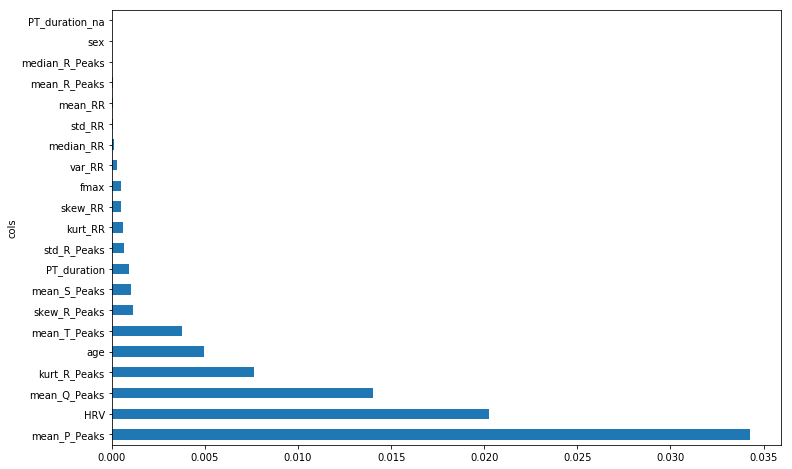

In [39]:
fi_mda = pd.DataFrame({'cols':X_train_drop.columns, 'imp':res.importances_mean.T}).sort_values('imp', ascending=False)

plot_fi(fi_mda);

Although not the same, the results are similar and make sense from a physiological point of view.

### Lets optimize our model based on MDI results

In [63]:
thresh = 0.025
to_keep = list(fi_mdi[fi_mdi['imp'] > thresh].cols)

X_train_keep = X_train_drop[to_keep]
X_eval_keep = X_eval_drop[to_keep]

len(to_keep)

15

In [93]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_keep, y_train)

print_fscores(m_af, X_eval_keep, y_eval)

CPU times: user 13.6 s, sys: 223 ms, total: 13.9 s
Wall time: 3.51 s
[0.929852704969497, 0.9733660417031718]


In [67]:
mlflow.set_experiment('AF_feature_testing')
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_keep.columns)))
    mlflow.log_param('threshold', thresh)
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval_keep), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval_keep), beta=2))
    # mlflow.sklearn.log_model(m_af, "Model")
                      

Now we removed some columns we check the feature importance in our new model to see if it changed due to interactions between our variables and one of the ones we discarded. 

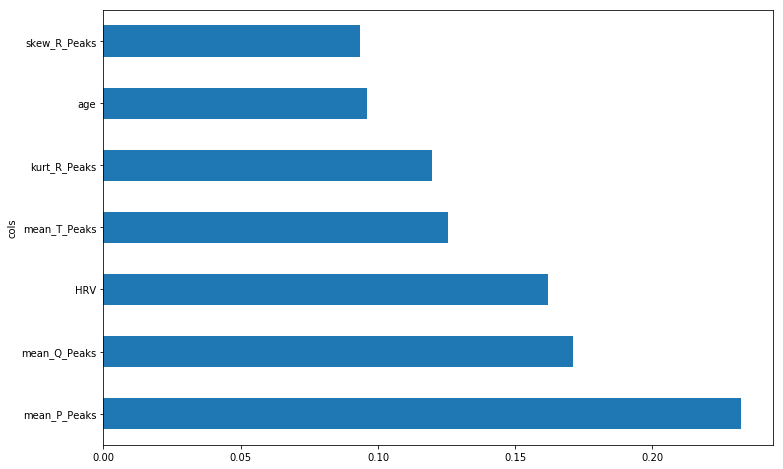

In [47]:
fi_mdi = rf_feat_importance(m_af, X_train_keep)
plot_fi(fi_mdi[:10]);

Let's save the current dataset

In [92]:
os.makedirs('datasets/fitted', exist_ok=True)

df = pd.concat([df_train, df_eval])
df.reset_index(inplace=True)
df.to_feather('datasets/fitted/af-dataset')

We save the current model to disk

In [95]:
pickle.dump(m_af, open('models/af/base/lead2', 'wb'))